In [446]:
# Goal: Data preprocessing, NLP, topic models with LDA (MALLET, Gensim), visualizaion (preliminary)
# Result: implementations of topic models with high coherence scores from each library
# Output: pyLDAvis, wordcloud, csvs (document-topic, topic-document...)
# Resource: https://www.machinelearningplus.com/nlp/topic-modeling

# Helper libraries
import re
from pprint import pprint
import pandas as pd
import numpy as np

# Text pre-processing
import spacy
import nltk

# Topic modeling wrapper, coherence
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud

In [3]:
# DATA Read in docs (corpus) from csv; report length of abstract text
docs = pd.read_csv("data/ERI-combined-2009-2019.csv")
len(docs)

# Concatenate title and abstract to new column for topic model
docs['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
docs.head()

# Calculate lengths of combined title and abstract; add columns to dataframe for length of abstracts
docs['title_len'] = docs['title'].apply(len)
docs['abstract_len'] = docs['abstract'].apply(len)
docs['combined_len'] = docs['combined'].apply(len)
#docs.head()

# Calculate summary statistics for combined title and abstract lengths to determine text suitability
docs.combined_len.describe()

count    3770.000000
mean     1678.432626
std       687.609548
min       128.000000
25%      1247.000000
50%      1630.000000
75%      1993.000000
max      7083.000000
Name: combined_len, dtype: float64

In [191]:
# DATA Title and abstract to list, removing new line characters, quotations
data = docs['combined'].values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data] #remove new line characters
data = [re.sub("\'", "", sent) for sent in data] #remove single quotes
pprint(data[:1])

['Streams and Urbanization Urbanization encompasses a diverse array of '
 'watershed alterations that influence the physical, chemical, and biological '
 'characteristics of streams. In this chapter, we summarize lessons learned '
 'from the last half century of research on urban streams and provide a '
 'critique of various mitigation strategies, including recent approaches that '
 'explicitly address geomorphic processes. We focus first on the abiotic '
 'conditions (primarily hydrologic and geomorphic) and their changes in '
 'streams that accompany urbanization, recognizing that these changes may vary '
 'with geomorphic context and climatic region. We then discuss technical '
 'approaches and limitations to (1) mitigating water-quantity and '
 'water-quality degradation through site design, riparian protection, and '
 'structural stormwater-management strategies; and (2) restoring urban streams '
 'in those watersheds where the economic, social, and political contexts can '
 'supp

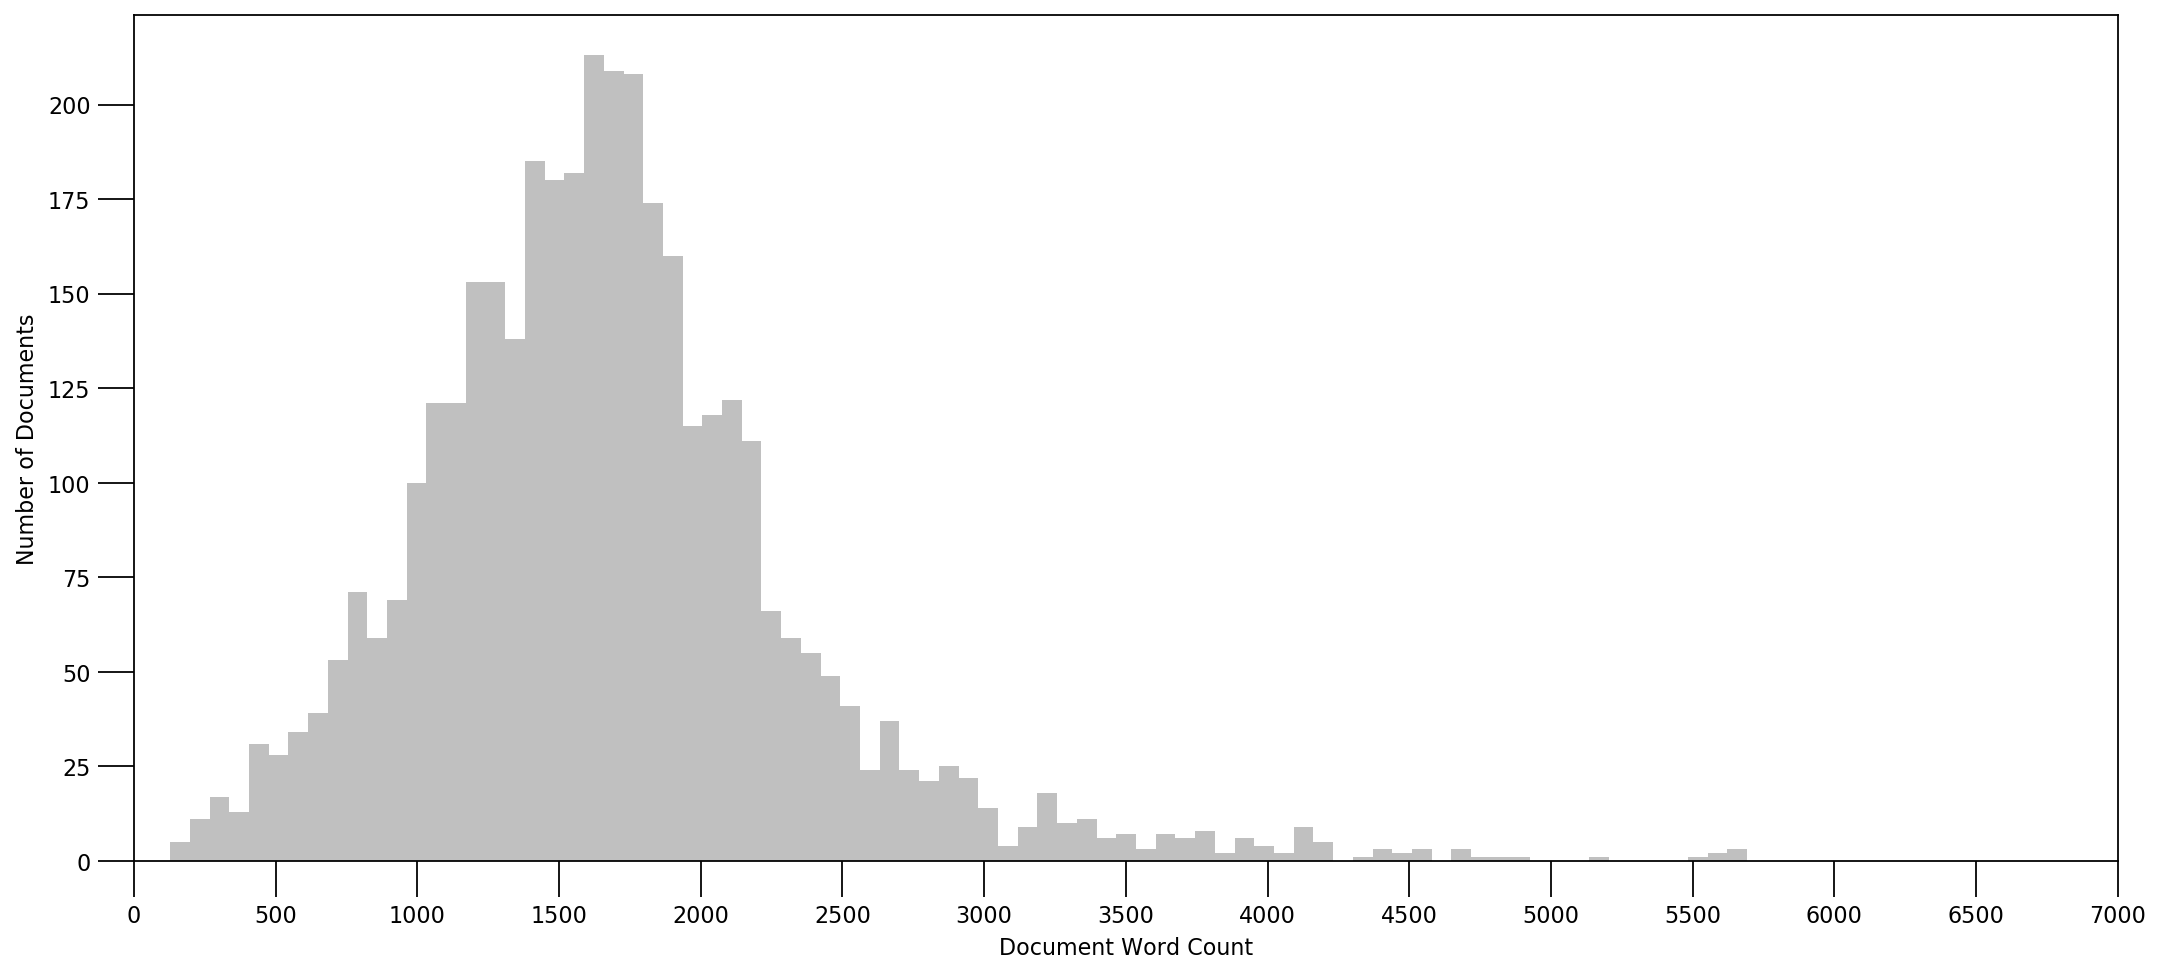

In [95]:
# DATA Frequency distribution of word counts in documents
doc_lens = [len(d) for d in docs.combined]

# Plot distribution of documents (titles & abstracts)
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='silver')
plt.gca().set(xlim=(0, 7000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,7000,15))
plt.show()
#plt.savefig('figures/word-count-dist.png')

In [190]:
# NLP Load stopwords from NLTK, extend default list with custom stopwords (from frequent terms)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['data', 'study', 'project', 'research', 'collaborative', 'use', 
                   'include', 'result', 'increase', 'high', 'low', 'large', 'include', 'based'])

In [192]:
# NLP Tokenize each sentence into a list of lowercase words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True remove punctuation

data_words = list(sent_to_words(data))

print(data_words[:1])

[['streams', 'and', 'urbanization', 'urbanization', 'encompasses', 'diverse', 'array', 'of', 'watershed', 'alterations', 'that', 'influence', 'the', 'physical', 'chemical', 'and', 'biological', 'characteristics', 'of', 'streams', 'in', 'this', 'chapter', 'we', 'summarize', 'lessons', 'learned', 'from', 'the', 'last', 'half', 'century', 'of', 'research', 'on', 'urban', 'streams', 'and', 'provide', 'critique', 'of', 'various', 'mitigation', 'strategies', 'including', 'recent', 'approaches', 'that', 'explicitly', 'address', 'geomorphic', 'processes', 'we', 'focus', 'first', 'on', 'the', 'abiotic', 'conditions', 'primarily', 'hydrologic', 'and', 'geomorphic', 'and', 'their', 'changes', 'in', 'streams', 'that', 'accompany', 'urbanization', 'recognizing', 'that', 'these', 'changes', 'may', 'vary', 'with', 'geomorphic', 'context', 'and', 'climatic', 'region', 'we', 'then', 'discuss', 'technical', 'approaches', 'and', 'limitations', 'to', 'mitigating', 'water', 'quantity', 'and', 'water', 'qua

In [8]:
# NLP Bigram and trigram models (words frequently occurring together in the doc)
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=80) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example (given a specific record)
print(trigram_mod[bigram_mod[data_words[1]]])

['evidence', 'for', 'widespread', 'creep', 'on', 'the', 'flanks', 'of', 'the', 'sea', 'of', 'marmara', 'transform', 'basin', 'from', 'marine', 'geophysical', 'data', 'wave', 'fields', 'have', 'long', 'been', 'recognized', 'in', 'marine', 'sediments', 'on', 'the', 'flanks', 'of', 'basins', 'and', 'oceans', 'in', 'both', 'tectonically_active', 'and', 'inactive', 'environments', 'the', 'origin', 'of', 'waves', 'hereafter', 'called', 'undulations', 'is', 'controversial', 'competing', 'models', 'ascribe', 'them', 'to', 'depositional', 'processes', 'gravity', 'driven', 'downslope', 'creep', 'or', 'collapse', 'and', 'or', 'tectonic', 'shortening', 'here', 'we', 'analyze', 'pervasive', 'undulation', 'fields', 'identified', 'in', 'swath', 'bathymetry', 'and', 'new', 'high', 'resolution', 'multichannel_seismic', 'mcs', 'reflection', 'data', 'from', 'the', 'sea', 'of', 'marmara', 'turkey', 'although', 'they', 'exhibit', 'some', 'of', 'the', 'classical', 'features', 'of', 'sediment', 'waves', 'the

In [9]:
# NLP Define functions for stopwords, bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [193]:
# NLP Remove stopwords, make bigrams, make trigrams, and lemmatize
data_words_nostops = remove_stopwords(data_words) # stop words
data_words_bigrams = make_bigrams(data_words_nostops) # bigrams
data_words_trigrams = make_trigrams(data_words_bigrams) # trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stream', 'urbanization', 'urbanization', 'encompass', 'diverse', 'array', 'watershed', 'alteration', 'influence', 'physical', 'chemical', 'biological', 'characteristic', 'stream', 'chapter', 'summarize', 'lessons_learn', 'last', 'half', 'century', 'urban', 'stream', 'provide', 'critique', 'various', 'mitigation', 'strategy', 'include', 'recent', 'approach', 'explicitly', 'address', 'geomorphic', 'process', 'focus', 'first', 'abiotic', 'condition', 'primarily', 'hydrologic', 'geomorphic', 'change', 'stream', 'accompany', 'urbanization', 'recognize', 'change', 'may', 'vary', 'geomorphic', 'context', 'climatic', 'region', 'discuss', 'technical', 'approach', 'limitation', 'mitigate', 'water', 'quantity', 'water', 'quality', 'degradation', 'site', 'design', 'riparian', 'protection', 'structural', 'stormwater', 'management', 'strategy', 'restore', 'urban', 'stream', 'watershed', 'economic', 'social', 'political', 'context', 'support', 'activity']]


In [194]:
# NLP Create dictionary and corpus for topic modeling
# Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View corpus based on term-frequency
#print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Save dictionary and corpus for reuse - optional
#import pickle
#pickle.dump(corpus, open('outputs/LDA-corpus.pkl', 'wb'))
#id2word.save('outputs/LDA-dictionary.gensim')

[[('abiotic', 1),
  ('accompany', 1),
  ('activity', 1),
  ('address', 1),
  ('alteration', 1),
  ('approach', 2),
  ('array', 1),
  ('biological', 1),
  ('century', 1),
  ('change', 2),
  ('chapter', 1),
  ('characteristic', 1),
  ('chemical', 1),
  ('climatic', 1),
  ('condition', 1),
  ('context', 2),
  ('critique', 1),
  ('degradation', 1),
  ('design', 1),
  ('discuss', 1),
  ('diverse', 1),
  ('economic', 1),
  ('encompass', 1),
  ('explicitly', 1),
  ('first', 1),
  ('focus', 1),
  ('geomorphic', 3),
  ('half', 1),
  ('hydrologic', 1),
  ('include', 1),
  ('influence', 1),
  ('last', 1),
  ('lessons_learn', 1),
  ('limitation', 1),
  ('management', 1),
  ('may', 1),
  ('mitigate', 1),
  ('mitigation', 1),
  ('physical', 1),
  ('political', 1),
  ('primarily', 1),
  ('process', 1),
  ('protection', 1),
  ('provide', 1),
  ('quality', 1),
  ('quantity', 1),
  ('recent', 1),
  ('recognize', 1),
  ('region', 1),
  ('restore', 1),
  ('riparian', 1),
  ('site', 1),
  ('social', 1),
  

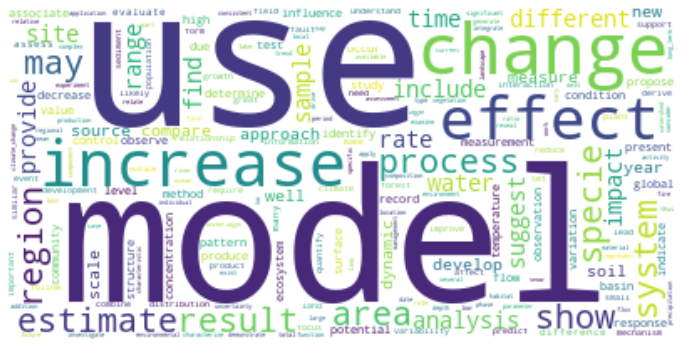

In [195]:
# NLP Display the lemmatized data with stopwords removed to see most frequent terms
flat_list = []
for sublist in texts: #flatten the list of lists from lemmatized texts in previous step
    for item in sublist:
        flat_list.append(item)

wordcloud = WordCloud(background_color='white').generate(' '.join(flat_list))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#plt.savefig('figures/wordcloud-cleaned-corpus.png')

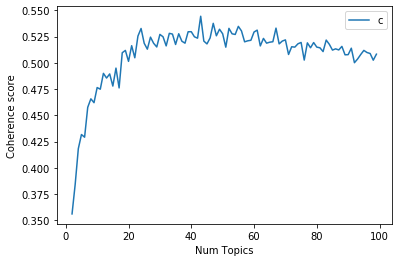

<Figure size 432x288 with 0 Axes>

In [22]:
# TOPIC MODELING (LDA) - MALLET, Find optimal number of topics for LDA (up to limit) 
# Approach: build many LDA models with different topic numbers (k); find the one with the highest coherence value
# Goal: choose an inflection point (k) that marks the end of a rapid growth of topic coherence

mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=1)

# Show graph
#plt.style.use("ggplot")
#matplotlib.rcParams.update({"font.size": 14})
#fig = plt.figure(figsize=(13,7))
#ax = plt.plot(x, coherence_values)
limit=100; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#plt.savefig('figures/LDA-coherence-V2.png')

In [26]:
# TOPIC MODELING (LDA) - MALLET, Print the coherence scores from the previous run; select highest score (47 topics)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3561
Num Topics = 3  has Coherence Value of 0.3842
Num Topics = 4  has Coherence Value of 0.4182
Num Topics = 5  has Coherence Value of 0.4317
Num Topics = 6  has Coherence Value of 0.4292
Num Topics = 7  has Coherence Value of 0.4576
Num Topics = 8  has Coherence Value of 0.4657
Num Topics = 9  has Coherence Value of 0.462
Num Topics = 10  has Coherence Value of 0.4764
Num Topics = 11  has Coherence Value of 0.4749
Num Topics = 12  has Coherence Value of 0.49
Num Topics = 13  has Coherence Value of 0.4855
Num Topics = 14  has Coherence Value of 0.4894
Num Topics = 15  has Coherence Value of 0.4779
Num Topics = 16  has Coherence Value of 0.495
Num Topics = 17  has Coherence Value of 0.4761
Num Topics = 18  has Coherence Value of 0.5096
Num Topics = 19  has Coherence Value of 0.5118
Num Topics = 20  has Coherence Value of 0.5014
Num Topics = 21  has Coherence Value of 0.5163
Num Topics = 22  has Coherence Value of 0.5048
Num Topics = 23  has Cohe

In [47]:
# TOPIC MODELING (LDA) - MALLET, Build a model with the highest coherence score (43 topics)
mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             id2word=id2word, 
                                             num_topics=43,
                                             #optimize_interval=10,
                                             random_seed=1)

# Compute coherence score, verify that it is the same as in the previous run (higher is better)
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5344536069725072


In [526]:
# OUTPUT - Topic, keyword, and keyword weight to CSV
top_words_per_topic = []
for t in range(ldamallet.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamallet.show_topic(t, topn = 10)])
topic_keyword_weights = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Keyword', 'Weight'])
#topic_keyword_weights.shape
#topic_keyword_weights.to_csv('outputs/LDA-43-topic-keyword-weights.csv')

In [527]:
# OUTPUT - Topic, keywords to CSV
topic_keyword_weights.drop(columns=['Weight'])
topic_keywords = topic_keyword_weights.groupby('Topic')['Keyword'].agg(lambda col: ', '.join(col))
df_topic_keywords = topic_keywords.to_frame()
#df_topic_keywords.shape
#df_topic_keywords.to_csv('outputs/LDA-43-topic-keywords.csv')

In [530]:
# OUTPUT - Document, dominant topic, percent contribution, keywords, text to CSV
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]): # dominant topic for each document
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # dominant topic, percent contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)  # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index() # Format as table
df_dominant_topic.columns = ['Document', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#df_dominant_topic.head(10)
#df_dominant_topic.shape
#df_dominant_topic.to_csv('outputs/LDA-43-document-topic.csv') #save to csv

In [531]:
# OUTPUT - Document, topic weight matrix to CSV
#model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet) #transform MALLET model to Gensim LDA for use
#topics = model.get_document_topics(corpus, per_word_topics=True) #store doc_topics for all the documents in the corpus
#all_topics = [(doc_topics, word_topics, phi_values) for doc_topics, word_topics, phi_values in topics]
#doc_topics, word_topics, phi_values = all_topics[4] # as example, access details of doc 3
#print('Document topic:', doc_topics, "\n")
#print('Word topic:', word_topics, "\n")
#print('Phi value:', phi_values)

rows = [] 
for doc_topics, word_topics, phi_values in all_topics:
    rows.append([doc_topics, word_topics, phi_values])
topics_df = pd.DataFrame(rows, columns=['doc_topics', 'word_topics', 'phi_values'])
topics_df['Document'] = np.arange(len(topics_df))
topics_df.head()

result = pd.merge(df_dominant_topic, topics_df, on='Document', how='left', indicator=True) # join on 'Document' key
result_updated = result.drop(columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'word_topics', 'phi_values', '_merge', 'Text'])

document_topics = result_updated.doc_topics.to_list()
topics = sum(document_topics, [])
topics = set([topic[0] for topic in topics])
for i, document_topic in enumerate(document_topics):
    document_topic = dict(document_topic)
    document_topics[i] = []
    for topic in topics:
        document_topics[i].append(document_topic[topic] if topic in document_topic else 0)
columns = [f'topic_{i}' for i in topics]
df_new = pd.DataFrame(data=document_topics, columns=columns)

df_new.insert(0, 'Document', np.arange(len(df_new)))
df_new.head(10)
# df_new.shape
#df_new.to_csv('outputs/LDA-43-document-topic-weights.csv') #save out to csv

Document   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
0         0  0.028083  0.037252  0.013117  0.012793  0.020133  0.067268   
1         1  0.011989  0.082984  0.011428  0.017277  0.000000  0.016164   
2         2  0.181800  0.000000  0.000000  0.000000  0.000000  0.023592   
3         3  0.000000  0.000000  0.012971  0.000000  0.000000  0.000000   
4         4  0.011332  0.011330  0.000000  0.000000  0.000000  0.000000   
5         5  0.000000  0.230323  0.000000  0.076518  0.000000  0.018086   
6         6  0.000000  0.000000  0.041861  0.014787  0.000000  0.019102   
7         7  0.000000  0.039371  0.000000  0.000000  0.000000  0.000000   
8         8  0.028135  0.000000  0.017995  0.000000  0.000000  0.000000   
9         9  0.010840  0.000000  0.015852  0.022054  0.000000  0.000000   

    topic_6   topic_7   topic_8  ...  topic_33  topic_34  topic_35  topic_36  \
0  0.011509  0.010928  0.013702  ...  0.012086  0.000000  0.010908  0.136963   
1  0.015225  0.011976  0.246416  ...  0.000000  0.017698  0.027005  0.011778   
2  0.000000  0.011233  0.000000  ...  0.074754  0.000000  0.000000  0.000000   
3  0.102765  0.000000  0.000000  ...  0.000000  0.000000  0.019202  0.011129   
4  0.000000  0.018368  0.000000  ...  0.000000  0.018618  0.028178  0.000000   
5  0.000000  0.046427  0.000000  ...  0.015392  0.000000  0.000000  0.024469   
6  0.000000  0.039214  0.011328  ...  0.016406  0.000000  0.044369  0.018904   
7  0.000000  0.012676  0.380250  ...  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.035947  0.000000  ...  0.000000  0.098228  0.014616  0.000000   
9  0.012955  0.014535  0.010259  ...  0.025351  0.010179  0.020077  0.047095   

   topic_37  topic_38  topic_39  topic_40  topic_41  topic_42  
0  0.040432  0.000000  0.015972  0.012903  0.000000  0.000000  
1  0.000000  0.010955  0.010638  0.014741  0.000000  0.000000  
2  0.010082  0.000000  0.000000  0.000000  0.015306  0.000000  
3  0.000000  0.010749  0.035670  0.000000  0.052134  0.013492  
4  0.043402  0.000000  0.010119  0.000000  0.025768  0.026066  
5  0.000000  0.013055  0.011148  0.000000  0.017441  0.015676  
6  0.000000  0.010319  0.000000  0.012526  0.016213  0.000000  
7  0.000000  0.000000  0.000000  0.014840  0.000000  0.000000  
8  0.014330  0.010899  0.000000  0.010331  0.000000  0.000000  
9  0.011081  0.028747  0.030119  0.000000  0.013552  0.040066  

[10 rows x 44 columns]

In [612]:
# OUTPUT - Document, title, text, PI to CSV
# TO DO: explode by PI; join with ERI PI list (to filter out non-ERI affiliated researchers)
docs.insert(0, 'Document', np.arange(len(docs)))
combined = pd.merge(docs, df_new, on='Document', how='left', indicator=True) # join on 'Document' key

pubs = pd.read_csv("data/ERI-publications-2009-2019.csv")
pubs.insert(0, 'Type', "publication")
pubs_renamed = pubs.rename(columns={"dim_title": "title", "Authors": "pis", "dim_description": "abstract"})
pubs_renamed.dtypes

proj = pd.read_csv("data/ERI-projects-2009-2019.csv")
proj.insert(0, 'Type', "project")
proj.head() #fields to get: Type, title, start-year, end-year, pis
proj.dtypes

df_concat = pd.concat([pubs_renamed, proj], sort=False)
df_merge = pd.merge(df_concat, combined, on='title', how='left') # join on 'title' key
for col in df_merge.columns: print(col) 
    
df_merge_updated = df_merge.drop(columns = ['id_x', 'Rank', 'dim_type', 
                         'Publication ID', 'dim_url', 'PMID', 'PMCID', 'Title', 'Anthology title', 'MeSH terms', 
                        'Publication Date', 'Volume', 'Issue', 'Pagination', 'Open Access', 'Publication Type', 
                         'Corresponding Author', 'Authors Affiliations', 'Times cited', 'dimensions_title', 'dimensions_description',
                        'dimensions_type', 'dimensions_url', 'Recent citations', 'RCR', 'FCR', 'Source Linkout', 'Dimensions URL',
                        'FOR 1', 'FOR 2', 'FOR 3', 'FOR 4', 'FOR 5', 'start', 'end', 'id_y', 'title_len', 'abstract_len', 
                        'combined_len', '_merge', 'abstract_x'])
df_merge_updated.dtypes
df_dropped = df_merge_updated.dropna(how='any', subset=['Document'])# drop records without Document id
df_dropped.set_index('Document')
df_dropped = df_dropped[['Document','title','abstract_y','combined', 'pis', 'DOI', 'Source title', 'PubYear', 
                         'FOR (ANZSRC) Categories', 'filename', 'amount', 'agency', 'relationship', 'id.1', 
                         'start-year', 'end-year', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 
                         'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 
                         'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 
                         'topic_19', 'topic_20', 'topic_21', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 
                         'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 
                         'topic_32', 'topic_33', 'topic_34', 'topic_35', 'topic_36', 'topic_37', 'topic_38', 
                         'topic_39', 'topic_40', 'topic_41', 'topic_42']]
df_renamed = df_dropped.rename(columns={"Document": "document", "abstract_y": "abstract", 
                                        "Source title": "source_title", "PubYear": "publication_year", 
                                        "FOR (ANZSRC) Categories": "for_categories", "id.1": "project_id", 
                                        "start-year": "start_year", "end-year": "end_year"})
df_sorted = df_renamed.sort_values(by=['document'])
df_sorted.to_csv('outputs/LDA-43-document-topic-pis.csv') #save out to csv

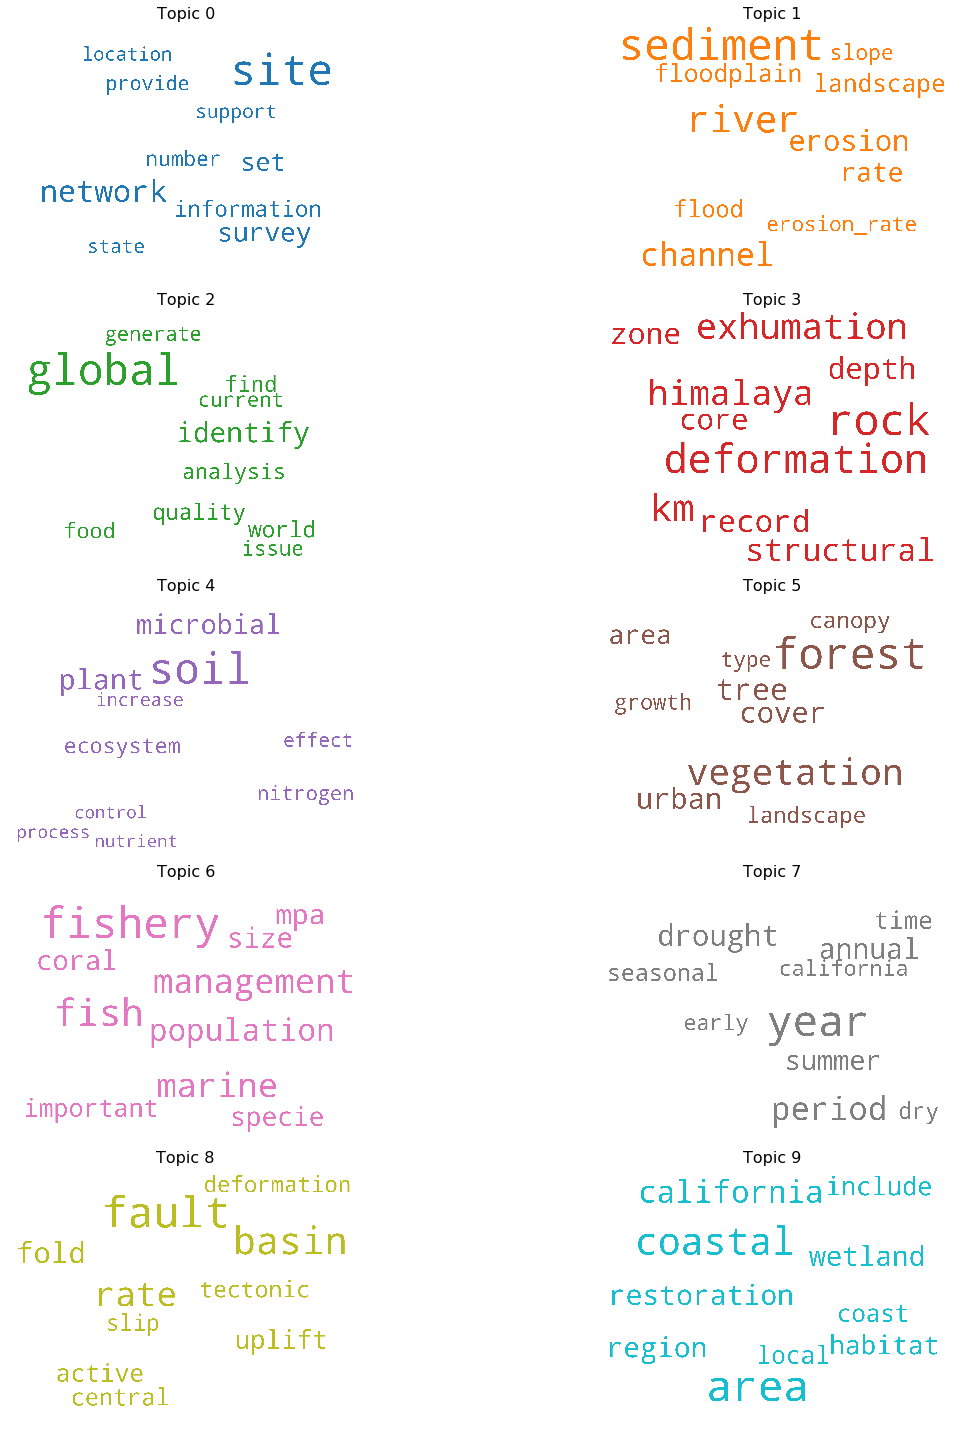

In [312]:
# VISUALIZATION - Wordcloud of top N words in each topic
# TO DO: visualize all topic wordclouds (beyond first 10)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(num_topics=-1, num_words=10, formatted=False) #uses the converted Gensim model
#topics = ldamallet.show_topics(formatted=False) #uses the MALLET model
#pprint(topics) #see tuple structure of topics [(topic), [('keyword', 'weight'), ('keyword', 'weight')...]]

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    #print(topic_words)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16)) #topic numbers are incorrect (instead check print(topics) and print(topic_words))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#plt.savefig('figures/LDA-mallet-43-word-clouds.png') #exports graphic

In [316]:
# VISUALIZATION - Topic model interface with pyLDAvis
# TO DO: offset topic numbers by 1 to match model exactly
#model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet) #convert Mallet model into a LdaModel
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word, sort_topics=False) #match topic order to Gensim model
pyLDAvis.save_html(vis, 'pyLDAvis/lda-mallet-43-V2.html') #save pyLDAvis graph as standalone webpage
vis

/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.089769  0.135135       1        1  2.067305
1      0.144590 -0.034234       2        1  2.700180
2     -0.127630  0.073424       3        1  1.945760
3      0.250672 -0.003286       4        1  2.347431
4     -0.056625 -0.188672       5        1  2.419409
5     -0.001589 -0.072568       6        1  2.212410
6     -0.139659 -0.060573       7        1  2.137706
7      0.080580 -0.087854       8        1  2.246968
8      0.228654  0.006639       9        1  2.770659
9     -0.015519  0.030002      10        1  2.001919
10    -0.082463 -0.209316      11        1  2.119189
11    -0.082578  0.144962      12        1  2.621224
12    -0.013542  0.062413      13        1  1.908432
13     0.086149  0.122321      14        1  2.402573
14     0.049396 -0.112363      15        1  2.239263
15    -0.130026 -0.200427      16        1  2.466557
16     0.031941 -0.038903      17        1  2.063401
17     0.221179  0.019874      18        1  2.525517
18     0.011370 -0.044778      19        1  2.210286
19    -0.074599  0.122998      20        1  2.539182
20     0.212098 -0.028766      21        1  2.490924
21    -0.025745 -0.135981      22        1  2.034676
22     0.124781  0.037693      23        1  2.282049
23     0.061392  0.035845      24        1  1.929696
24    -0.009671 -0.006290      25        1  2.178442
25     0.032185 -0.001731      26        1  2.280666
26     0.144247  0.006302      27        1  2.730835
27     0.010028  0.135231      28        1  2.394329
28    -0.079261 -0.156713      29        1  2.368726
29     0.082196  0.077150      30        1  2.215722
30    -0.046319  0.154658      31        1  2.197860
31    -0.137156  0.201411      32        1  2.570693
32    -0.073511 -0.013410      33        1  2.599170
33    -0.139463 -0.044547      34        1  2.080359
34    -0.063856  0.214776      35        1  2.505725
35     0.030864  0.003786      36        1  2.388694
36    -0.206929  0.052137      37        1  2.698587
37    -0.054327 -0.179289      38        1  2.525085
38    -0.020537  0.200560      39        1  2.279185
39    -0.136196 -0.089425      40        1  2.142003
40     0.081724 -0.052623      41        1  2.567127
41     0.054654 -0.062944      42        1  2.383557
42    -0.131728 -0.012621      43        1  2.210519, topic_info=     Category         Freq            Term        Total  loglift  logprob
120   Default  4368.000000           model  4368.000000  30.0000  30.0000
64    Default  2802.000000           water  2802.000000  29.0000  29.0000
9     Default  2404.000000          change  2404.000000  28.0000  28.0000
227   Default  1744.000000          specie  1744.000000  27.0000  27.0000
912   Default  1358.000000            soil  1358.000000  26.0000  26.0000
337   Default  1396.000000         climate  1396.000000  25.0000  25.0000
784   Default  1616.000000           scale  1616.000000  24.0000  24.0000
137   Default  1300.000000         spatial  1300.000000  23.0000  23.0000
41    Default  1634.000000         process  1634.000000  22.0000  22.0000
1222  Default  1166.000000     temperature  1166.000000  21.0000  21.0000
466   Default  1207.000000            year  1207.000000  20.0000  20.0000
713   Default   897.000000            snow   897.000000  19.0000  19.0000
529   Default  1481.000000            area  1481.000000  18.0000  18.0000
978   Default   870.000000          forest   870.000000  17.0000  17.0000
813   Default   959.000000            land   959.000000  16.0000  16.0000
487   Default  1160.000000          global  1160.000000  15.0000  15.0000
387   Default  1682.000000          system  1682.000000  14.0000  14.0000
281   Default  1405.000000          impact  1405.000000  13.0000  13.0000
261   Default  1675.000000          effect  1675.000000  12.0000  12.0000
51    Default  1012.000000            site  1012.000000  11.0000  11.0000
1706  Default  101